In [47]:
import warnings
from tqdm.auto import tqdm

import numpy as np
import helper
import algorithms
from itertools import permutations
import pandas as pd

In [48]:
warnings.filterwarnings('ignore')

num_iterations = 5
mean_size = 2
var_size = 0.1
FILTER_OE = False
DEBUG = False
EPS = 1

algo_list = ['hope_guardrail_35']
problem_list = ['C']
order_list = ['lcb', 'mean', 'cv']
num_groups = [50]

In [49]:
pd_d = pd.read_csv('data/Demand.csv')
pd_d.head()

,research_service_event_id,research_family_id,date_key,start_time_key,end_time_key,loc_id,event_id,service_id,service_type_grouping,service_type_sub_grouping,...,ages_60_64,ages_65_84,ages_85_over,member_ages,pounds_served,pieces_served,dollars_served,signature_method_id,signature_method_name,hands_on_referral
0,83604,43584,20160728.0,1100.0,1144.0,1232,1740,1,1,1,...,0,1,0,25|27|40|66,0.0,0.0,0.0,20,Signed Electronic Form,No
1,83605,43584,20160729.0,1100.0,1127.0,466,639,1,1,1,...,0,1,0,22|27|66,0.0,0.0,0.0,20,Signed Electronic Form,Yes
2,83606,43585,20160824.0,1000.0,1017.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No
3,83607,43585,20160830.0,900.0,918.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No
4,83608,43585,20160928.0,900.0,925.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No


In [50]:
pd_d.dropna(inplace=True)

In [51]:
pd_d.date_key = pd.to_datetime(pd_d.date_key, format='%Y%m%d')

In [52]:
pd_d

,research_service_event_id,research_family_id,date_key,start_time_key,end_time_key,loc_id,event_id,service_id,service_type_grouping,service_type_sub_grouping,...,ages_60_64,ages_65_84,ages_85_over,member_ages,pounds_served,pieces_served,dollars_served,signature_method_id,signature_method_name,hands_on_referral
0,83604,43584,2016-07-28,1100.0,1144.0,1232,1740,1,1,1,...,0,1,0,25|27|40|66,0.0,0.0,0.0,20,Signed Electronic Form,No
1,83605,43584,2016-07-29,1100.0,1127.0,466,639,1,1,1,...,0,1,0,22|27|66,0.0,0.0,0.0,20,Signed Electronic Form,Yes
2,83606,43585,2016-08-24,1000.0,1017.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No
3,83607,43585,2016-08-30,900.0,918.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No
4,83608,43585,2016-09-28,900.0,925.0,515,709,1,1,1,...,0,0,0,41,0.0,0.0,0.0,20,Signed Electronic Form,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490711,1664246,410023,2017-06-28,1300.0,1352.0,949,1387,68,1,4,...,0,3,0,10|10|26|65|65|65,0.0,0.0,0.0,20,Signed Electronic Form,No
490712,1664247,410024,2017-06-28,1300.0,1354.0,949,1387,68,1,4,...,0,0,0,18|35|35|35,0.0,0.0,0.0,20,Signed Electronic Form,No
490713,1664248,410025,2017-06-20,1000.0,1000.0,1213,2986,81,9,1,...,0,0,0,49,0.0,0.0,0.0,21,No Signature Required,No
490714,1664249,410026,2017-06-29,1600.0,1646.0,549,743,1,1,1,...,1,0,0,54|62,0.0,0.0,0.0,20,Signed Electronic Form,No


In [53]:
grouped_pd_d = pd_d.groupby('date_key').agg({
    'pounds_served': 'sum',
    'pieces_served': 'sum',
    'dollars_served': 'sum'
})

In [54]:
grouped_pd_d

,pounds_served,pieces_served,dollars_served
date_key,,,
2015-11-24,0.0,2.0,43.00
2016-07-01,0.0,15.0,331.18
2016-07-02,0.0,0.0,0.00
2016-07-03,0.0,0.0,0.00
2016-07-04,0.0,3.0,43.18
...,...,...,...
2017-11-28,0.0,3.0,12.00
2018-01-03,0.0,2.0,8.00
2018-01-25,0.0,1.0,12.00


<Axes: xlabel='date_key'>

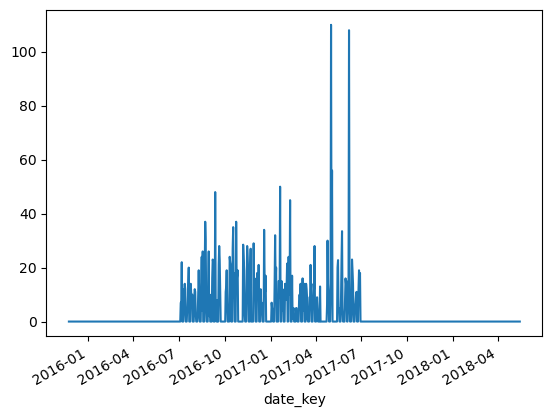

In [55]:
grouped_pd_d['pounds_served'].plot()

<Axes: xlabel='date_key'>

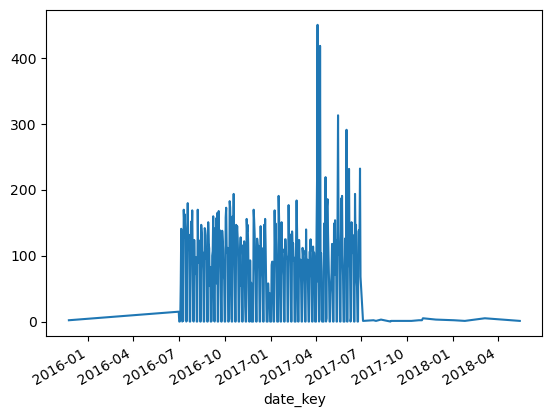

In [56]:
grouped_pd_d['pieces_served'].plot()

<Axes: xlabel='date_key'>

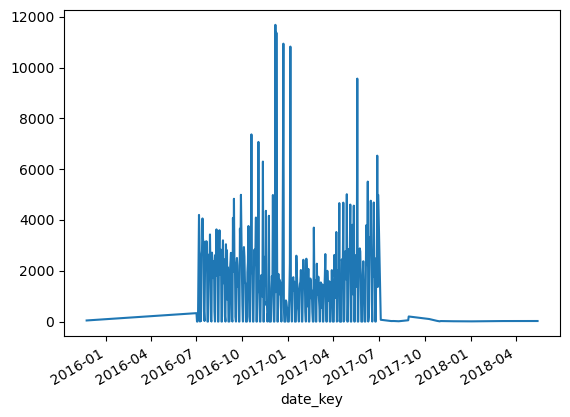

In [57]:
grouped_pd_d['dollars_served'].plot()

In [58]:
start_date = pd.to_datetime('2016-07-01')
end_date = pd.to_datetime('2017-07-31')

truncated_pd_d = grouped_pd_d[(grouped_pd_d.index >= start_date) & (grouped_pd_d.index <= end_date)]

In [59]:
truncated_pd_d

,pounds_served,pieces_served,dollars_served
date_key,,,
2016-07-01,0.0,15.0,331.18
2016-07-02,0.0,0.0,0.00
2016-07-03,0.0,0.0,0.00
2016-07-04,0.0,3.0,43.18
2016-07-05,7.0,57.0,1924.24
...,...,...,...
2017-06-29,18.0,232.5,1362.23
2017-06-30,0.0,68.0,4984.42
2017-07-05,0.0,1.0,69.95


<Axes: xlabel='date_key'>

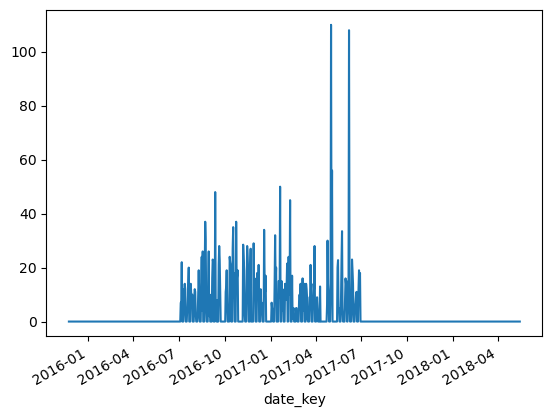

In [60]:
grouped_pd_d['pounds_served'].plot()

<Axes: xlabel='date_key'>

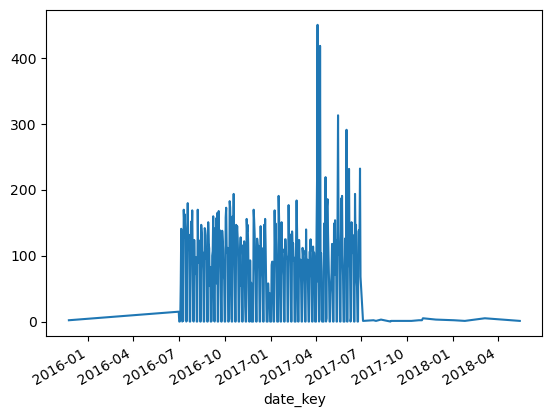

In [61]:
grouped_pd_d['pieces_served'].plot()

<Axes: xlabel='date_key'>

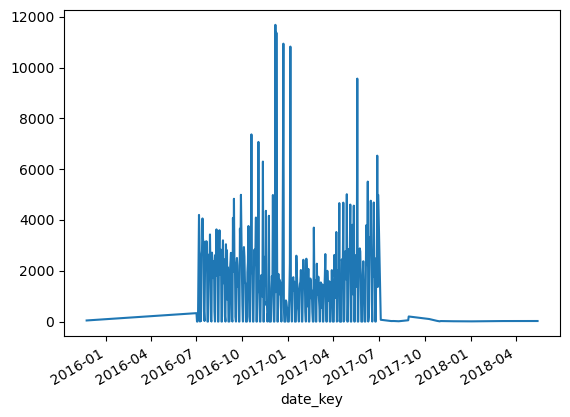

In [62]:
grouped_pd_d['dollars_served'].plot()

In [63]:
truncated_pd_d['pounds_served'].to_list()

[0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 7.0,
 22.0,
 0.0,
 0.0,
 0.0,
 12.0,
 6.0,
 14.0,
 4.0,
 0.0,
 0.0,
 0.0,
 5.0,
 12.0,
 14.0,
 20.0,
 0.0,
 0.0,
 0.0,
 14.0,
 10.0,
 10.0,
 10.0,
 0.0,
 0.0,
 0.0,
 9.0,
 12.0,
 11.0,
 3.0,
 0.0,
 0.0,
 0.0,
 2.0,
 10.0,
 19.0,
 10.0,
 0.0,
 0.0,
 0.0,
 14.0,
 24.0,
 4.0,
 26.0,
 0.0,
 0.0,
 0.0,
 17.0,
 37.0,
 30.0,
 5.0,
 0.0,
 0.0,
 0.0,
 12.0,
 26.0,
 2.0,
 10.0,
 0.0,
 0.0,
 0.0,
 0.0,
 16.0,
 23.0,
 22.0,
 0.0,
 0.0,
 0.0,
 48.0,
 6.0,
 7.0,
 0.0,
 8.0,
 0.0,
 0.0,
 21.0,
 28.0,
 23.0,
 12.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 11.0,
 13.0,
 19.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24.0,
 22.0,
 21.0,
 0.0,
 0.0,
 0.0,
 27.0,
 35.0,
 9.0,
 18.0,
 0.0,
 0.0,
 0.0,
 37.0,
 15.0,
 17.0,
 19.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 28.5,
 24.0,
 19.0,
 3.0,
 0.0,
 0.0,
 0.0,
 14.0,
 28.0,
 24.0,
 19.0,
 0.0,
 0.0,
 0.0,
 19.0,
 27.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 29.0,
 11.0,
 16.0,
 14.0,
 0.0,
 0.0,
 0.0,


In [64]:
pounds_served_list = truncated_pd_d['pounds_served'].to_list()
pounds_served_list_no_zeros = [value for value in pounds_served_list if value != 0]

In [65]:
pieces_served_list = truncated_pd_d['pieces_served'].to_list()
pieces_served_list_no_zeros = [value for value in pieces_served_list if value != 0]

dollars_served_list = truncated_pd_d['dollars_served'].to_list()
dollars_served_list_no_zeros = [value for value in dollars_served_list if value != 0]

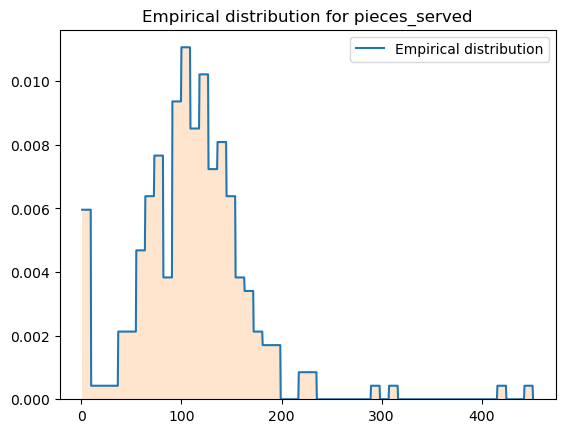

In [66]:
import matplotlib.pyplot as plt
from scipy.stats import rv_histogram

# Create a histogram from the data
hist = np.histogram(pieces_served_list_no_zeros, bins=50, density=True)

# Create a random variable from the histogram
hist_dist = rv_histogram(hist)

# Generate values for the x-axis
x = np.linspace(min(pieces_served_list_no_zeros), max(pieces_served_list_no_zeros), 1000)

# Generate values for the y-axis
y = hist_dist.pdf(x)

# Plot the empirical distribution
plt.plot(x, y, label='Empirical distribution')
plt.hist(pieces_served_list_no_zeros, density=True, alpha=0.2, bins=50)
plt.title('Empirical distribution for pieces_served')
plt.legend()
plt.show()

In [67]:
def demand_dist(n, mean_size=0.1, var_size=0.1):
    samples = hist_dist.rvs(size=n)
    mean_samples = np.mean(samples)
    scaling_factor = mean_size / mean_samples
    scaled_samples = samples * scaling_factor
    return scaled_samples

In [68]:
warnings.filterwarnings('ignore')

num_iterations = 5
mean_size = 1
var_size = 0.1
FILTER_OE = False
DEBUG = False
EPS = 3

algo_list = ['hope_guardrail_35']
problem_list = ['C']
order_list = ['lcb', 'mean', 'cv']
num_groups = [50]


for setup in problem_list:
    file_name = "uniform_perishing_table_" + str(setup).replace('.', '-')
    print(f'Running for: {file_name}')

    data = []

    for n in tqdm(num_groups):
        n = int(n)
        max_budget = mean_size * n

        if setup == 'A':
            EPS = 1
        elif setup == 'B':
            EPS = 4
        elif setup == 'C':
            EPS = 1

        if setup == 'A':
            def perish_dist(b, n):
                if b < (mean_size * n / 2):
                    mean = n / 2
                    d_range = EPS * b * (1 / mean_size)
                else:
                    mean = n
                    d_range = 0
                val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(mean - d_range, mean + d_range))))
                return val

            mean_list = np.asarray([n / 2 if b < (mean_size * n / 2) else n for b in range(max_budget)])
            range_list = np.asarray([EPS * b * (1 / mean_size) if b < (mean_size * n / 2) else 0 for b in range(max_budget)])
            stdev_list = np.sqrt((1 / 3) * (range_list ** 2))
            CV = stdev_list / mean_list

        elif setup == 'B':
            def perish_dist(b, n):
                if b < (mean_size * n / 2):
                    low_range = b + 1
                    up_range = b + 1
                else:
                    low_range = b + 1
                    up_range = n
                val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(low_range, up_range))))
                return val

            low_range = np.asarray([b + 1 if b < (mean_size * n / 2) else b + 1 for b in range(max_budget)])
            up_range = np.asarray([b + 1 if b < (mean_size * n / 2) else n for b in range(max_budget)])
            mean_list = (1 / 2) * (low_range + up_range)
            stdev_list = np.sqrt((1 / 12) * ((up_range - low_range) ** 2))
            CV = stdev_list / mean_list

        elif setup == 'C':
            def perish_dist(b, n):
                if b < (mean_size * n / 2):
                    low_range = b + 1
                    up_range = b + 1
                else:
                    low_range = (b + 1 - (mean_size * n / 2))
                    up_range = (b + 1 + (mean_size * n / 2))
                val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(low_range, up_range))))
                return val

            low_range = np.asarray([b + 1 if b < (mean_size * n / 1.2) else (b + 1 - (mean_size * n / 1.2)) for b in range(max_budget)])
            up_range = np.asarray([b + 1 if b < (mean_size * n / 1.2) else (b + 1 + (mean_size * n / 1.2)) for b in range(max_budget)])
            mean_list = (1 / 2) * (low_range + up_range)
            stdev_list = np.sqrt((1 / 12) * ((up_range - low_range) ** 2))
            CV = stdev_list / mean_list

        offset_prob = helper.check_offset_expiry(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget)
        print(f' Probability process is offset expiring: {100 * offset_prob}')

        n_upper = helper.n_upper(lambda n: demand_dist(n, mean_size, var_size), n)
        num_valid = 0
        x_lower_no_perish = (max_budget / n_upper[0])
        print(f'X_lower_no_perishing: {x_lower_no_perish}')

        if 'opt' in order_list:
            max_x_lower_perish = 0
            for order in list(permutations(list(range(0, max_budget)))):
                x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper, order)
                if x_lower_perish >= max_x_lower_perish:
                    opt_order = order
                    max_x_lower_perish = x_lower_perish
            print(f'Optimal Order: {opt_order} and x_lower: {max_x_lower_perish}')

        for _ in tqdm(range(num_iterations)):
            demands = demand_dist(n, mean_size, var_size)
            resource_perish = np.asarray([perish_dist(b, n) for b in range(max_budget)])

            check_optimality = [(max_budget / np.sum(demands)) * np.sum(demands[:(t + 1)]) - np.count_nonzero([resource_perish <= t]) for t in range(n)]
            if FILTER_OE:
                if np.min(check_optimality) < 0:
                    continue
                else:
                    num_valid += 1
            else:
                num_valid += 1

            xopt = max_budget / np.sum(demands)

            for algo in algo_list:
                for alloc_order in order_list:

                    if alloc_order == 'mean':
                        order = np.lexsort((np.random.random(mean_list.size), mean_list))
                    elif alloc_order == 'cv':
                        order = np.lexsort((np.random.random(mean_list.size), (-1) * CV))
                    elif alloc_order == 'lcb':
                        lcb = low_range + .05 * (up_range - low_range)
                        order = np.lexsort((np.random.random(mean_list.size), lcb))
                    elif alloc_order == 'ucb':
                        ucb = low_range + .05 * (up_range - low_range)
                        order = np.lexsort((np.random.random(mean_list.size), ucb))
                    elif alloc_order == 'random':
                        order = np.random.permutation(max_budget)
                    elif alloc_order == 'flipped':
                        order = np.lexsort((np.random.random(mean_list.size), (-1) * mean_list))
                    elif alloc_order == 'opt':
                        order = opt_order

                    if alloc_order != 'opt':
                        x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper)
                    else:
                        x_lower_perish = max_x_lower_perish

                    if DEBUG: print(f"Alloc Order: {alloc_order} and order: {order} and x_lower: {x_lower_perish}")
                    if setup == 'A' and alloc_order in ['lcb', 'cv']:
                        x_lower_perish = x_lower_no_perish
                    if algo == 'static_x_lower':
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.fixed_threshold(
                            demands, resource_perish, max_budget, xopt, x_lower_perish, n, order)
                    elif algo == 'static_b_over_n':
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.fixed_threshold(
                            demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, order)
                    elif algo.startswith('hope_guardrail'):
                        exponent = float(algo.split('_')[-1]) * -0.01
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.hope_guardrail_perish(
                            demands, resource_perish, max_budget, xopt, x_lower_perish, n, mean_size * (n ** exponent),
                            lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper, order)
                    elif algo.startswith('og_hope_guardrail'):
                        exponent = float(algo.split('_')[-1]) * -0.01
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.hope_guardrail_original(
                            demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, mean_size * (n ** exponent),
                            lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper, order)

                    data_dicts = [
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Delta_Perish', 'Value': x_lower_no_perish - x_lower_perish},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Hindsight_Envy', 'Value': hindsight_envy},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Counterfactual_Envy', 'Value': counterfactual_envy},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Waste', 'Value': waste},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Perished_Un_Allocated', 'Value': perish_un_allocate},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Stockout', 'Value': stockout}
                    ]
                    data.extend(data_dicts)


Running for: uniform_perishing_table_C


  0%|          | 0/1 [00:00<?, ?it/s]

 Probability process is offset expiring: 0.8
X_lower_no_perishing: 0.9999999827662118


  0%|          | 0/5 [00:00<?, ?it/s]

Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.13999998276621106
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.13999998276621106
Starting value: 0.9999999827662118
Final value: 0.13999998276621106
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.13999998276621106
Starting value: 0.9999999827662118
Final value: 0.13999998276621106
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 0.12999998276621105
Starting value: 0.9999999827662118
Final value: 

In [69]:
import warnings
warnings.filterwarnings('ignore')

num_iterations = 5
mean_size = 1
var_size = 0.1
FILTER_OE = False
DEBUG = False
EPS = 3

algo_list = ['hope_guardrail_35']
problem_list = ['C']
order_list = ['lcb', 'mean', 'cv']
num_groups = [50]

for setup in problem_list:
    file_name = f"uniform_perishing_table_{setup.replace('.', '-')}"
    print(f'Running for: {file_name}')

    data = []

    for n in tqdm(num_groups):
        n = int(n)
        max_budget = mean_size * n

        EPS = {'A': 1, 'B': 4, 'C': 1}.get(setup, 3)

        if setup == 'A':
            def perish_dist(b, n):
                mean = n / 2 if b < (mean_size * n / 2) else n
                d_range = EPS * b * (1 / mean_size) if b < (mean_size * n / 2) else 0
                return np.ceil(np.clip(np.random.uniform(mean - d_range, mean + d_range), 0, n))

            mean_list = np.array([n / 2 if b < (mean_size * n / 2) else n for b in range(max_budget)])
            range_list = np.array([EPS * b * (1 / mean_size) if b < (mean_size * n / 2) else 0 for b in range(max_budget)])
            stdev_list = np.sqrt((1 / 3) * (range_list ** 2))
            CV = stdev_list / mean_list

        elif setup == 'B':
            def perish_dist(b, n):
                low_range, up_range = (b + 1, b + 1) if b < (mean_size * n / 2) else (b + 1, n)
                return np.ceil(np.clip(np.random.uniform(low_range, up_range), 0, n))

            low_range = np.array([b + 1 if b < (mean_size * n / 2) else b + 1 for b in range(max_budget)])
            up_range = np.array([b + 1 if b < (mean_size * n / 2) else n for b in range(max_budget)])
            mean_list = 0.5 * (low_range + up_range)
            stdev_list = np.sqrt((1 / 12) * ((up_range - low_range) ** 2))
            CV = stdev_list / mean_list

        elif setup == 'C':
            def perish_dist(b, n):
                if b < (mean_size * n / 2):
                    low_range, up_range = b + 1, b + 1
                else:
                    low_range = b + 1 - (mean_size * n / 2)
                    up_range = b + 1 + (mean_size * n / 2)
                return np.ceil(np.clip(np.random.uniform(low_range, up_range), 0, n))

            low_range = np.array([b + 1 if b < (mean_size * n / 1.2) else b + 1 - (mean_size * n / 1.2) for b in range(max_budget)])
            up_range = np.array([b + 1 if b < (mean_size * n / 1.2) else b + 1 + (mean_size * n / 1.2) for b in range(max_budget)])
            mean_list = 0.5 * (low_range + up_range)
            stdev_list = np.sqrt((1 / 12) * ((up_range - low_range) ** 2))
            CV = stdev_list / mean_list

        offset_prob = helper.check_offset_expiry(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget)
        print(f'Probability process is offset expiring: {100 * offset_prob:.2f}%')

        n_upper = helper.n_upper(lambda n: demand_dist(n, mean_size, var_size), n)
        x_lower_no_perish = max_budget / n_upper[0]
        print(f'X_lower_no_perishing: {x_lower_no_perish}')

        if 'opt' in order_list:
            max_x_lower_perish = 0
            for order in permutations(range(max_budget)):
                x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper, order)
                if x_lower_perish >= max_x_lower_perish:
                    opt_order = order
                    max_x_lower_perish = x_lower_perish
            print(f'Optimal Order: {opt_order} and x_lower: {max_x_lower_perish}')

        for _ in tqdm(range(num_iterations)):
            demands = demand_dist(n, mean_size, var_size)
            resource_perish = np.array([perish_dist(b, n) for b in range(max_budget)])

            check_optimality = [(max_budget / demands.sum()) * demands[:t + 1].sum() - np.count_nonzero(resource_perish <= t) for t in range(n)]
            if FILTER_OE and np.min(check_optimality) < 0:
                continue
            num_valid += 1

            xopt = max_budget / demands.sum()

            for algo in algo_list:
                for alloc_order in order_list:
                    if alloc_order == 'mean':
                        order = np.lexsort((np.random.random(mean_list.size), mean_list))
                    elif alloc_order == 'cv':
                        order = np.lexsort((np.random.random(mean_list.size), -CV))
                    elif alloc_order == 'lcb':
                        lcb = low_range + 0.05 * (up_range - low_range)
                        order = np.lexsort((np.random.random(mean_list.size), lcb))
                    elif alloc_order == 'ucb':
                        ucb = low_range + 0.05 * (up_range - low_range)
                        order = np.lexsort((np.random.random(mean_list.size), ucb))
                    elif alloc_order == 'random':
                        order = np.random.permutation(max_budget)
                    elif alloc_order == 'flipped':
                        order = np.lexsort((np.random.random(mean_list.size), -mean_list))
                    elif alloc_order == 'opt':
                        order = opt_order

                    x_lower_perish = max_x_lower_perish if alloc_order == 'opt' else helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper)
                    if DEBUG: print(f"Alloc Order: {alloc_order} and order: {order} and x_lower: {x_lower_perish}")
                    if setup == 'A' and alloc_order in ['lcb', 'cv']:
                        x_lower_perish = x_lower_no_perish

                    if algo == 'static_x_lower':
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.fixed_threshold(demands, resource_perish, max_budget, xopt, x_lower_perish, n, order)
                    elif algo == 'static_b_over_n':
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.fixed_threshold(demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, order)
                    elif algo.startswith('hope_guardrail'):
                        exponent = float(algo.split('_')[-1]) * -0.01
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.hope_guardrail_perish(demands, resource_perish, max_budget, xopt, x_lower_perish, n, mean_size * (n ** exponent), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper, order)
                    elif algo.startswith('og_hope_guardrail'):
                        exponent = float(algo.split('_')[-1]) * -0.01
                        perish_un_allocate, waste, counterfactual_envy, hindsight_envy, stockout = algorithms.hope_guardrail_original(demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, mean_size * (n ** exponent), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper, order)

                    data.extend([
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Delta_Perish', 'Value': x_lower_no_perish - x_lower_perish},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Hindsight_Envy', 'Value': hindsight_envy},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Counterfactual_Envy', 'Value': counterfactual_envy},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Waste', 'Value': waste},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Perished_Un_Allocated', 'Value': perish_un_allocate},
                        {'NumGroups': n, 'Algorithm': algo, 'Order': alloc_order, 'Norm': 'Stockout', 'Value': stockout}
                    ])


Running for: uniform_perishing_table_C


  0%|          | 0/1 [00:00<?, ?it/s]

Probability process is offset expiring: 1.10%
X_lower_no_perishing: 0.9999999825380026


  0%|          | 0/5 [00:00<?, ?it/s]

Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 0.12999998253800182
Starting value: 0.9999999825380026
Final value: 0.13999998253800183
Starting value: 0.9999999825380026
Final value: 